In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras import Model, Input, Sequential, regularizers, losses, optimizers, regularizers, initializers
from keras.layers import Activation, Dense, LSTM, Embedding, Dropout, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression
%matplotlib inline

Using TensorFlow backend.


In [42]:
dataset = pd.read_csv('tenn_dist_12.csv')
dataset.drop(columns='time', inplace=True)

In [43]:
target = 'product'
shift = 30

## Preprocessing

In [44]:
desc = dataset.describe(include='all').T
useless = desc[(desc['std']==0.) | (desc['unique']==1)]
dataset.drop(columns=useless.index, inplace=True)

dataset.drop(0, inplace=True)

In [45]:
dataset_c = dataset.copy()

In [46]:
dataset.rename(columns={target:target+str(-shift)}, inplace=True)

dataset[target] = dataset[target+str(-shift)].shift(-shift)
dataset.dropna(inplace=True)

In [47]:
target_mean = dataset[target].mean()
target_std = dataset[target].std()
stand = StandardScaler()
dataset = pd.DataFrame(stand.fit_transform(dataset), dataset.index, columns=dataset.columns)

In [48]:
dataset_c = pd.DataFrame(stand.fit_transform(dataset_c), dataset_c.index, columns=dataset_c.columns)

In [49]:
def un_stand_target(x):
    return x*target_std+target_mean    

## Linear models

In [50]:
total = {}

In [51]:
trainX, testX, trainY, testY = train_test_split(dataset.drop(columns=target), dataset[target], test_size=0.25, shuffle=False)

In [52]:
linear_models = [LinearRegression, RandomForestRegressor, XGBRegressor]
sizes = [500,1000,2000,5000,10000,20000,len(trainX)]

for model_t in linear_models:

    name = model_t.__name__
    total[name] = {}

    for size in sizes:

        model = model_t()

        model.fit(trainX[:size], trainY[:size])
        preds = model.predict(testX)
        result = mean_squared_error(un_stand_target(testY), un_stand_target(preds))

        print(f'{size:5} {name:21} {result:.4f}')

        total[name][size] = result

  500 LinearRegression      4.2903
 1000 LinearRegression      47.6526
 2000 LinearRegression      6.6827
 5000 LinearRegression      0.3454
10000 LinearRegression      0.1572
20000 LinearRegression      0.0366
35976 LinearRegression      0.0209
  500 RandomForestRegressor 0.0782
 1000 RandomForestRegressor 0.0684
 2000 RandomForestRegressor 0.1319
 5000 RandomForestRegressor 0.0563
10000 RandomForestRegressor 0.0457
20000 RandomForestRegressor 0.0276
35976 RandomForestRegressor 0.0189
  500 XGBRegressor          0.0857
 1000 XGBRegressor          0.0699
 2000 XGBRegressor          0.0962
 5000 XGBRegressor          0.0505
10000 XGBRegressor          0.0304
20000 XGBRegressor          0.0257
35976 XGBRegressor          0.0167


## Neural

In [21]:
n_feats = len(dataset.columns)-1

In [862]:
def Neural():
#     np.random.seed(2)
    inputs = Input((n_feats,))
    x = Dense(200, activation='tanh')(inputs)
    x = Dropout(.5)(x)
    x = Dense(1)(x)
    neural = Model(inputs=inputs, outputs=x)
    neural.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae', metrics=['mse'])
    return neural

In [885]:
total['Neural'] = {}
sizes = [500,5000,15000,len(trainX)]
# sizes = [len(trainX)]
full_hist_val = {}
full_hist_loss = {}
result_std = {}

for size in sizes:
    model = Neural()
        
    model.fit(trainX[:size], trainY[:size], epochs=500+size//70, batch_size=10000,
              validation_data=(testX, testY), shuffle=False, verbose=1,
              callbacks=[ModelCheckpoint('tmp_model.hdf5', monitor='val_mean_squared_error', save_best_only=True, save_weights_only=True)])
    
    full_hist_val[size] = model.history.history['val_mean_squared_error']
    full_hist_loss[size] = model.history.history['mean_squared_error']
    
    model.load_weights('tmp_model.hdf5')
    preds = model.predict(testX)
    
    result_std[size] = mean_squared_error(preds, testY)
    result = mean_squared_error(un_stand_target(preds), un_stand_target(testY))
    print('\n----->', size, result, '\n')
    total['Neural'][size] = result

Train on 500 samples, validate on 11993 samples
Epoch 1/507
500/500 [==============================] - 11s 23ms/step - loss: 1.0444 - mean_squared_error: 1.6405 - val_loss: 0.9919 - val_mean_squared_error: 1.4024
Epoch 2/507
500/500 [==============================] - 0s 59us/step - loss: 0.8428 - mean_squared_error: 1.0729 - val_loss: 1.0338 - val_mean_squared_error: 1.4913
Epoch 3/507
500/500 [==============================] - 0s 53us/step - loss: 0.8998 - mean_squared_error: 1.2573 - val_loss: 1.0417 - val_mean_squared_error: 1.5065
Epoch 4/507
500/500 [==============================] - 0s 57us/step - loss: 0.8987 - mean_squared_error: 1.2321 - val_loss: 1.0275 - val_mean_squared_error: 1.4718
Epoch 5/507
500/500 [==============================] - 0s 54us/step - loss: 0.9018 - mean_squared_error: 1.3139 - val_loss: 1.0010 - val_mean_squared_error: 1.4099
Epoch 6/507
500/500 [==============================] - 0s 51us/step - loss: 0.8310 - mean_squared_error: 1.0806 - val_loss: 0.9711 

Epoch 51/507
500/500 [==============================] - 0s 52us/step - loss: 0.5025 - mean_squared_error: 0.4075 - val_loss: 0.8790 - val_mean_squared_error: 1.1088
Epoch 52/507
500/500 [==============================] - 0s 53us/step - loss: 0.5032 - mean_squared_error: 0.4037 - val_loss: 0.8788 - val_mean_squared_error: 1.1104
Epoch 53/507
500/500 [==============================] - 0s 67us/step - loss: 0.4919 - mean_squared_error: 0.3938 - val_loss: 0.8804 - val_mean_squared_error: 1.1149
Epoch 54/507
500/500 [==============================] - 0s 55us/step - loss: 0.4840 - mean_squared_error: 0.3847 - val_loss: 0.8801 - val_mean_squared_error: 1.1144
Epoch 55/507
500/500 [==============================] - 0s 52us/step - loss: 0.4845 - mean_squared_error: 0.3777 - val_loss: 0.8788 - val_mean_squared_error: 1.1125
Epoch 56/507
500/500 [==============================] - 0s 57us/step - loss: 0.4586 - mean_squared_error: 0.3369 - val_loss: 0.8790 - val_mean_squared_error: 1.1132
Epoch 57/5

Epoch 101/507
500/500 [==============================] - 0s 55us/step - loss: 0.3403 - mean_squared_error: 0.1932 - val_loss: 0.8619 - val_mean_squared_error: 1.0809
Epoch 102/507
500/500 [==============================] - 0s 54us/step - loss: 0.3456 - mean_squared_error: 0.1971 - val_loss: 0.8676 - val_mean_squared_error: 1.0943
Epoch 103/507
500/500 [==============================] - 0s 54us/step - loss: 0.3394 - mean_squared_error: 0.1918 - val_loss: 0.8706 - val_mean_squared_error: 1.1030
Epoch 104/507
500/500 [==============================] - 0s 53us/step - loss: 0.3593 - mean_squared_error: 0.2071 - val_loss: 0.8708 - val_mean_squared_error: 1.1061
Epoch 105/507
500/500 [==============================] - 0s 56us/step - loss: 0.3355 - mean_squared_error: 0.1874 - val_loss: 0.8713 - val_mean_squared_error: 1.1099
Epoch 106/507
500/500 [==============================] - 0s 55us/step - loss: 0.3257 - mean_squared_error: 0.1862 - val_loss: 0.8730 - val_mean_squared_error: 1.1159
Epoc

Epoch 151/507
500/500 [==============================] - 0s 49us/step - loss: 0.2928 - mean_squared_error: 0.1383 - val_loss: 0.8794 - val_mean_squared_error: 1.1290
Epoch 152/507
500/500 [==============================] - 0s 52us/step - loss: 0.2837 - mean_squared_error: 0.1284 - val_loss: 0.8785 - val_mean_squared_error: 1.1272
Epoch 153/507
500/500 [==============================] - 0s 51us/step - loss: 0.2813 - mean_squared_error: 0.1352 - val_loss: 0.8804 - val_mean_squared_error: 1.1295
Epoch 154/507
500/500 [==============================] - 0s 52us/step - loss: 0.2845 - mean_squared_error: 0.1309 - val_loss: 0.8821 - val_mean_squared_error: 1.1316
Epoch 155/507
500/500 [==============================] - 0s 54us/step - loss: 0.2858 - mean_squared_error: 0.1351 - val_loss: 0.8824 - val_mean_squared_error: 1.1316
Epoch 156/507
500/500 [==============================] - 0s 53us/step - loss: 0.2821 - mean_squared_error: 0.1298 - val_loss: 0.8801 - val_mean_squared_error: 1.1276
Epoc

Epoch 201/507
500/500 [==============================] - 0s 55us/step - loss: 0.2590 - mean_squared_error: 0.1128 - val_loss: 0.8854 - val_mean_squared_error: 1.1602
Epoch 202/507
500/500 [==============================] - 0s 52us/step - loss: 0.2664 - mean_squared_error: 0.1116 - val_loss: 0.8865 - val_mean_squared_error: 1.1620
Epoch 203/507
500/500 [==============================] - 0s 59us/step - loss: 0.2570 - mean_squared_error: 0.1021 - val_loss: 0.8877 - val_mean_squared_error: 1.1637
Epoch 204/507
500/500 [==============================] - 0s 54us/step - loss: 0.2567 - mean_squared_error: 0.1061 - val_loss: 0.8885 - val_mean_squared_error: 1.1644
Epoch 205/507
500/500 [==============================] - 0s 52us/step - loss: 0.2504 - mean_squared_error: 0.1018 - val_loss: 0.8859 - val_mean_squared_error: 1.1590
Epoch 206/507
500/500 [==============================] - 0s 51us/step - loss: 0.2567 - mean_squared_error: 0.1081 - val_loss: 0.8817 - val_mean_squared_error: 1.1510
Epoc

Epoch 251/507
500/500 [==============================] - 0s 56us/step - loss: 0.2375 - mean_squared_error: 0.0911 - val_loss: 0.8699 - val_mean_squared_error: 1.1392
Epoch 252/507
500/500 [==============================] - 0s 52us/step - loss: 0.2346 - mean_squared_error: 0.0878 - val_loss: 0.8685 - val_mean_squared_error: 1.1374
Epoch 253/507
500/500 [==============================] - 0s 52us/step - loss: 0.2368 - mean_squared_error: 0.0865 - val_loss: 0.8672 - val_mean_squared_error: 1.1360
Epoch 254/507
500/500 [==============================] - 0s 54us/step - loss: 0.2285 - mean_squared_error: 0.0867 - val_loss: 0.8669 - val_mean_squared_error: 1.1365
Epoch 255/507
500/500 [==============================] - 0s 58us/step - loss: 0.2309 - mean_squared_error: 0.0840 - val_loss: 0.8673 - val_mean_squared_error: 1.1382
Epoch 256/507
500/500 [==============================] - 0s 57us/step - loss: 0.2292 - mean_squared_error: 0.0867 - val_loss: 0.8688 - val_mean_squared_error: 1.1415
Epoc

Epoch 301/507
500/500 [==============================] - 0s 53us/step - loss: 0.2148 - mean_squared_error: 0.0765 - val_loss: 0.8593 - val_mean_squared_error: 1.1303
Epoch 302/507
500/500 [==============================] - 0s 52us/step - loss: 0.2166 - mean_squared_error: 0.0780 - val_loss: 0.8593 - val_mean_squared_error: 1.1304
Epoch 303/507
500/500 [==============================] - 0s 52us/step - loss: 0.2212 - mean_squared_error: 0.0773 - val_loss: 0.8591 - val_mean_squared_error: 1.1308
Epoch 304/507
500/500 [==============================] - 0s 49us/step - loss: 0.2245 - mean_squared_error: 0.0817 - val_loss: 0.8597 - val_mean_squared_error: 1.1327
Epoch 305/507
500/500 [==============================] - 0s 51us/step - loss: 0.2292 - mean_squared_error: 0.0847 - val_loss: 0.8601 - val_mean_squared_error: 1.1339
Epoch 306/507
500/500 [==============================] - 0s 49us/step - loss: 0.2159 - mean_squared_error: 0.0746 - val_loss: 0.8607 - val_mean_squared_error: 1.1355
Epoc

Epoch 351/507
500/500 [==============================] - 0s 55us/step - loss: 0.2141 - mean_squared_error: 0.0749 - val_loss: 0.8571 - val_mean_squared_error: 1.1409
Epoch 352/507
500/500 [==============================] - 0s 53us/step - loss: 0.2136 - mean_squared_error: 0.0734 - val_loss: 0.8574 - val_mean_squared_error: 1.1418
Epoch 353/507
500/500 [==============================] - 0s 54us/step - loss: 0.2137 - mean_squared_error: 0.0740 - val_loss: 0.8574 - val_mean_squared_error: 1.1419
Epoch 354/507
500/500 [==============================] - 0s 52us/step - loss: 0.2196 - mean_squared_error: 0.0748 - val_loss: 0.8574 - val_mean_squared_error: 1.1419
Epoch 355/507
500/500 [==============================] - 0s 55us/step - loss: 0.2143 - mean_squared_error: 0.0746 - val_loss: 0.8569 - val_mean_squared_error: 1.1409
Epoch 356/507
500/500 [==============================] - 0s 53us/step - loss: 0.2133 - mean_squared_error: 0.0730 - val_loss: 0.8561 - val_mean_squared_error: 1.1392
Epoc

Epoch 401/507
500/500 [==============================] - 0s 54us/step - loss: 0.2062 - mean_squared_error: 0.0700 - val_loss: 0.8490 - val_mean_squared_error: 1.1192
Epoch 402/507
500/500 [==============================] - 0s 71us/step - loss: 0.2112 - mean_squared_error: 0.0740 - val_loss: 0.8482 - val_mean_squared_error: 1.1181
Epoch 403/507
500/500 [==============================] - 0s 53us/step - loss: 0.2091 - mean_squared_error: 0.0725 - val_loss: 0.8477 - val_mean_squared_error: 1.1174
Epoch 404/507
500/500 [==============================] - 0s 54us/step - loss: 0.2128 - mean_squared_error: 0.0737 - val_loss: 0.8474 - val_mean_squared_error: 1.1169
Epoch 405/507
500/500 [==============================] - 0s 54us/step - loss: 0.2127 - mean_squared_error: 0.0737 - val_loss: 0.8474 - val_mean_squared_error: 1.1172
Epoch 406/507
500/500 [==============================] - 0s 52us/step - loss: 0.2073 - mean_squared_error: 0.0697 - val_loss: 0.8477 - val_mean_squared_error: 1.1180
Epoc

Epoch 451/507
500/500 [==============================] - 0s 56us/step - loss: 0.2051 - mean_squared_error: 0.0692 - val_loss: 0.8544 - val_mean_squared_error: 1.1407
Epoch 452/507
500/500 [==============================] - 0s 55us/step - loss: 0.2068 - mean_squared_error: 0.0705 - val_loss: 0.8542 - val_mean_squared_error: 1.1404
Epoch 453/507
500/500 [==============================] - 0s 56us/step - loss: 0.2063 - mean_squared_error: 0.0698 - val_loss: 0.8544 - val_mean_squared_error: 1.1407
Epoch 454/507
500/500 [==============================] - 0s 59us/step - loss: 0.2072 - mean_squared_error: 0.0704 - val_loss: 0.8550 - val_mean_squared_error: 1.1416
Epoch 455/507
500/500 [==============================] - 0s 56us/step - loss: 0.2014 - mean_squared_error: 0.0674 - val_loss: 0.8556 - val_mean_squared_error: 1.1426
Epoch 456/507
500/500 [==============================] - 0s 57us/step - loss: 0.2096 - mean_squared_error: 0.0723 - val_loss: 0.8558 - val_mean_squared_error: 1.1431
Epoc

Epoch 501/507
500/500 [==============================] - 0s 59us/step - loss: 0.2026 - mean_squared_error: 0.0672 - val_loss: 0.8544 - val_mean_squared_error: 1.1474
Epoch 502/507
500/500 [==============================] - 0s 53us/step - loss: 0.2075 - mean_squared_error: 0.0713 - val_loss: 0.8543 - val_mean_squared_error: 1.1468
Epoch 503/507
500/500 [==============================] - 0s 55us/step - loss: 0.2060 - mean_squared_error: 0.0715 - val_loss: 0.8545 - val_mean_squared_error: 1.1466
Epoch 504/507
500/500 [==============================] - 0s 54us/step - loss: 0.2050 - mean_squared_error: 0.0696 - val_loss: 0.8547 - val_mean_squared_error: 1.1465
Epoch 505/507
500/500 [==============================] - 0s 54us/step - loss: 0.2067 - mean_squared_error: 0.0708 - val_loss: 0.8548 - val_mean_squared_error: 1.1463
Epoch 506/507
500/500 [==============================] - 0s 54us/step - loss: 0.2022 - mean_squared_error: 0.0673 - val_loss: 0.8549 - val_mean_squared_error: 1.1466
Epoc

Epoch 43/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.5199 - mean_squared_error: 0.4435 - val_loss: 0.6684 - val_mean_squared_error: 0.6916
Epoch 44/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.5173 - mean_squared_error: 0.4388 - val_loss: 0.6695 - val_mean_squared_error: 0.6909
Epoch 45/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.5139 - mean_squared_error: 0.4258 - val_loss: 0.6692 - val_mean_squared_error: 0.6892
Epoch 46/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.5014 - mean_squared_error: 0.4107 - val_loss: 0.6691 - val_mean_squared_error: 0.6877
Epoch 47/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.4952 - mean_squared_error: 0.3990 - val_loss: 0.6702 - val_mean_squared_error: 0.6882
Epoch 48/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.5005 - mean_squared_error: 0.4084 - val_loss: 0.6743 - val_mean_squared_error: 0.6917
Epoc

Epoch 93/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3603 - mean_squared_error: 0.2298 - val_loss: 0.6750 - val_mean_squared_error: 0.6662
Epoch 94/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3600 - mean_squared_error: 0.2290 - val_loss: 0.6759 - val_mean_squared_error: 0.6657
Epoch 95/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3620 - mean_squared_error: 0.2279 - val_loss: 0.6757 - val_mean_squared_error: 0.6639
Epoch 96/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3612 - mean_squared_error: 0.2261 - val_loss: 0.6740 - val_mean_squared_error: 0.6608
Epoch 97/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3560 - mean_squared_error: 0.2236 - val_loss: 0.6725 - val_mean_squared_error: 0.6578
Epoch 98/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3559 - mean_squared_error: 0.2213 - val_loss: 0.6717 - val_mean_squared_error: 0.6553
Epoc

Epoch 143/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3127 - mean_squared_error: 0.1821 - val_loss: 0.6576 - val_mean_squared_error: 0.6301
Epoch 144/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3162 - mean_squared_error: 0.1821 - val_loss: 0.6575 - val_mean_squared_error: 0.6302
Epoch 145/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3104 - mean_squared_error: 0.1783 - val_loss: 0.6574 - val_mean_squared_error: 0.6302
Epoch 146/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3113 - mean_squared_error: 0.1785 - val_loss: 0.6575 - val_mean_squared_error: 0.6304
Epoch 147/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3105 - mean_squared_error: 0.1775 - val_loss: 0.6574 - val_mean_squared_error: 0.6303
Epoch 148/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.3107 - mean_squared_error: 0.1770 - val_loss: 0.6571 - val_mean_squared_error: 0.629

5000/5000 [==============================] - 0s 8us/step - loss: 0.2936 - mean_squared_error: 0.1624 - val_loss: 0.6612 - val_mean_squared_error: 0.6335
Epoch 193/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2949 - mean_squared_error: 0.1631 - val_loss: 0.6606 - val_mean_squared_error: 0.6328
Epoch 194/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2968 - mean_squared_error: 0.1647 - val_loss: 0.6601 - val_mean_squared_error: 0.6322
Epoch 195/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.2950 - mean_squared_error: 0.1645 - val_loss: 0.6599 - val_mean_squared_error: 0.6319
Epoch 196/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2954 - mean_squared_error: 0.1643 - val_loss: 0.6597 - val_mean_squared_error: 0.6316
Epoch 197/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2912 - mean_squared_error: 0.1618 - val_loss: 0.6596 - val_mean_squared_error: 0.6316
Epoch 198/57

Epoch 242/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2863 - mean_squared_error: 0.1563 - val_loss: 0.6711 - val_mean_squared_error: 0.6450
Epoch 243/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2863 - mean_squared_error: 0.1552 - val_loss: 0.6706 - val_mean_squared_error: 0.6443
Epoch 244/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.2865 - mean_squared_error: 0.1559 - val_loss: 0.6705 - val_mean_squared_error: 0.6441
Epoch 245/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.2867 - mean_squared_error: 0.1551 - val_loss: 0.6705 - val_mean_squared_error: 0.6439
Epoch 246/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.2854 - mean_squared_error: 0.1551 - val_loss: 0.6705 - val_mean_squared_error: 0.6441
Epoch 247/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2872 - mean_squared_error: 0.1560 - val_loss: 0.6705 - val_mean_squared_error: 0.644

5000/5000 [==============================] - 0s 8us/step - loss: 0.2833 - mean_squared_error: 0.1521 - val_loss: 0.6837 - val_mean_squared_error: 0.6640
Epoch 292/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2833 - mean_squared_error: 0.1523 - val_loss: 0.6840 - val_mean_squared_error: 0.6644
Epoch 293/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2818 - mean_squared_error: 0.1506 - val_loss: 0.6845 - val_mean_squared_error: 0.6652
Epoch 294/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.2826 - mean_squared_error: 0.1520 - val_loss: 0.6852 - val_mean_squared_error: 0.6660
Epoch 295/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.2822 - mean_squared_error: 0.1509 - val_loss: 0.6861 - val_mean_squared_error: 0.6669
Epoch 296/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2832 - mean_squared_error: 0.1516 - val_loss: 0.6875 - val_mean_squared_error: 0.6683
Epoch 297/57

Epoch 341/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.2802 - mean_squared_error: 0.1469 - val_loss: 0.7030 - val_mean_squared_error: 0.6887
Epoch 342/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2789 - mean_squared_error: 0.1469 - val_loss: 0.7036 - val_mean_squared_error: 0.6893
Epoch 343/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2761 - mean_squared_error: 0.1446 - val_loss: 0.7036 - val_mean_squared_error: 0.6895
Epoch 344/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2786 - mean_squared_error: 0.1461 - val_loss: 0.7036 - val_mean_squared_error: 0.6897
Epoch 345/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2796 - mean_squared_error: 0.1472 - val_loss: 0.7039 - val_mean_squared_error: 0.6902
Epoch 346/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.2786 - mean_squared_error: 0.1472 - val_loss: 0.7047 - val_mean_squared_error: 0.691

5000/5000 [==============================] - 0s 8us/step - loss: 0.2775 - mean_squared_error: 0.1439 - val_loss: 0.7156 - val_mean_squared_error: 0.7055
Epoch 391/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2747 - mean_squared_error: 0.1431 - val_loss: 0.7163 - val_mean_squared_error: 0.7066
Epoch 392/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2762 - mean_squared_error: 0.1439 - val_loss: 0.7170 - val_mean_squared_error: 0.7078
Epoch 393/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2765 - mean_squared_error: 0.1449 - val_loss: 0.7169 - val_mean_squared_error: 0.7078
Epoch 394/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2776 - mean_squared_error: 0.1451 - val_loss: 0.7164 - val_mean_squared_error: 0.7071
Epoch 395/571
5000/5000 [==============================] - 0s 9us/step - loss: 0.2750 - mean_squared_error: 0.1419 - val_loss: 0.7161 - val_mean_squared_error: 0.7068
Epoch 396/57

Epoch 440/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2760 - mean_squared_error: 0.1431 - val_loss: 0.7243 - val_mean_squared_error: 0.7191
Epoch 441/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2749 - mean_squared_error: 0.1407 - val_loss: 0.7248 - val_mean_squared_error: 0.7196
Epoch 442/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2744 - mean_squared_error: 0.1405 - val_loss: 0.7254 - val_mean_squared_error: 0.7204
Epoch 443/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2738 - mean_squared_error: 0.1387 - val_loss: 0.7258 - val_mean_squared_error: 0.7214
Epoch 444/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2737 - mean_squared_error: 0.1409 - val_loss: 0.7274 - val_mean_squared_error: 0.7239
Epoch 445/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2761 - mean_squared_error: 0.1419 - val_loss: 0.7292 - val_mean_squared_error: 0.726

5000/5000 [==============================] - 0s 9us/step - loss: 0.2687 - mean_squared_error: 0.1353 - val_loss: 0.7396 - val_mean_squared_error: 0.7405
Epoch 490/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2696 - mean_squared_error: 0.1345 - val_loss: 0.7389 - val_mean_squared_error: 0.7400
Epoch 491/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2724 - mean_squared_error: 0.1403 - val_loss: 0.7392 - val_mean_squared_error: 0.7405
Epoch 492/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2703 - mean_squared_error: 0.1372 - val_loss: 0.7403 - val_mean_squared_error: 0.7421
Epoch 493/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2718 - mean_squared_error: 0.1381 - val_loss: 0.7418 - val_mean_squared_error: 0.7441
Epoch 494/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2704 - mean_squared_error: 0.1363 - val_loss: 0.7427 - val_mean_squared_error: 0.7453
Epoch 495/57

Epoch 539/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2706 - mean_squared_error: 0.1361 - val_loss: 0.7477 - val_mean_squared_error: 0.7546
Epoch 540/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2729 - mean_squared_error: 0.1365 - val_loss: 0.7475 - val_mean_squared_error: 0.7544
Epoch 541/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2721 - mean_squared_error: 0.1367 - val_loss: 0.7478 - val_mean_squared_error: 0.7546
Epoch 542/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2726 - mean_squared_error: 0.1373 - val_loss: 0.7483 - val_mean_squared_error: 0.7551
Epoch 543/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2721 - mean_squared_error: 0.1372 - val_loss: 0.7478 - val_mean_squared_error: 0.7544
Epoch 544/571
5000/5000 [==============================] - 0s 8us/step - loss: 0.2704 - mean_squared_error: 0.1358 - val_loss: 0.7471 - val_mean_squared_error: 0.753

Epoch 65/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.4465 - mean_squared_error: 0.3623 - val_loss: 0.4666 - val_mean_squared_error: 0.3817
Epoch 66/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.4462 - mean_squared_error: 0.3643 - val_loss: 0.4672 - val_mean_squared_error: 0.3820
Epoch 67/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.4394 - mean_squared_error: 0.3512 - val_loss: 0.4670 - val_mean_squared_error: 0.3818
Epoch 68/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.4373 - mean_squared_error: 0.3523 - val_loss: 0.4658 - val_mean_squared_error: 0.3811
Epoch 69/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.4400 - mean_squared_error: 0.3556 - val_loss: 0.4646 - val_mean_squared_error: 0.3805
Epoch 70/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.4335 - mean_squared_error: 0.3483 - val_loss: 0.4650 - val_mean_squared_error:

Epoch 114/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3964 - mean_squared_error: 0.3106 - val_loss: 0.4571 - val_mean_squared_error: 0.3743
Epoch 115/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3958 - mean_squared_error: 0.3079 - val_loss: 0.4573 - val_mean_squared_error: 0.3741
Epoch 116/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3976 - mean_squared_error: 0.3090 - val_loss: 0.4578 - val_mean_squared_error: 0.3738
Epoch 117/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3956 - mean_squared_error: 0.3057 - val_loss: 0.4583 - val_mean_squared_error: 0.3733
Epoch 118/714
15000/15000 [==============================] - 0s 6us/step - loss: 0.3939 - mean_squared_error: 0.3062 - val_loss: 0.4580 - val_mean_squared_error: 0.3728
Epoch 119/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3951 - mean_squared_error: 0.3076 - val_loss: 0.4574 - val_mean_squared_

15000/15000 [==============================] - 0s 5us/step - loss: 0.3728 - mean_squared_error: 0.2721 - val_loss: 0.4652 - val_mean_squared_error: 0.3628
Epoch 211/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3751 - mean_squared_error: 0.2744 - val_loss: 0.4656 - val_mean_squared_error: 0.3628
Epoch 212/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3741 - mean_squared_error: 0.2710 - val_loss: 0.4662 - val_mean_squared_error: 0.3629
Epoch 213/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3735 - mean_squared_error: 0.2708 - val_loss: 0.4656 - val_mean_squared_error: 0.3625
Epoch 214/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3746 - mean_squared_error: 0.2729 - val_loss: 0.4646 - val_mean_squared_error: 0.3619
Epoch 215/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3733 - mean_squared_error: 0.2717 - val_loss: 0.4641 - val_mean_squared_error: 0.3616


15000/15000 [==============================] - 0s 5us/step - loss: 0.3644 - mean_squared_error: 0.2548 - val_loss: 0.4726 - val_mean_squared_error: 0.3639
Epoch 307/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3642 - mean_squared_error: 0.2530 - val_loss: 0.4735 - val_mean_squared_error: 0.3645
Epoch 308/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3647 - mean_squared_error: 0.2564 - val_loss: 0.4742 - val_mean_squared_error: 0.3651
Epoch 309/714
15000/15000 [==============================] - 0s 6us/step - loss: 0.3633 - mean_squared_error: 0.2533 - val_loss: 0.4740 - val_mean_squared_error: 0.3653
Epoch 310/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3602 - mean_squared_error: 0.2503 - val_loss: 0.4747 - val_mean_squared_error: 0.3659
Epoch 311/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3625 - mean_squared_error: 0.2518 - val_loss: 0.4756 - val_mean_squared_error: 0.3663


15000/15000 [==============================] - 0s 5us/step - loss: 0.3553 - mean_squared_error: 0.2389 - val_loss: 0.4798 - val_mean_squared_error: 0.3729
Epoch 403/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3569 - mean_squared_error: 0.2411 - val_loss: 0.4796 - val_mean_squared_error: 0.3733
Epoch 404/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3558 - mean_squared_error: 0.2411 - val_loss: 0.4809 - val_mean_squared_error: 0.3747
Epoch 405/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3528 - mean_squared_error: 0.2380 - val_loss: 0.4818 - val_mean_squared_error: 0.3756
Epoch 406/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3565 - mean_squared_error: 0.2394 - val_loss: 0.4813 - val_mean_squared_error: 0.3755
Epoch 407/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3544 - mean_squared_error: 0.2388 - val_loss: 0.4805 - val_mean_squared_error: 0.3748


15000/15000 [==============================] - 0s 5us/step - loss: 0.3469 - mean_squared_error: 0.2276 - val_loss: 0.4854 - val_mean_squared_error: 0.3850
Epoch 499/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3475 - mean_squared_error: 0.2277 - val_loss: 0.4856 - val_mean_squared_error: 0.3846
Epoch 500/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3472 - mean_squared_error: 0.2286 - val_loss: 0.4857 - val_mean_squared_error: 0.3849
Epoch 501/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3493 - mean_squared_error: 0.2300 - val_loss: 0.4850 - val_mean_squared_error: 0.3849
Epoch 502/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3476 - mean_squared_error: 0.2280 - val_loss: 0.4862 - val_mean_squared_error: 0.3864
Epoch 503/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3482 - mean_squared_error: 0.2291 - val_loss: 0.4869 - val_mean_squared_error: 0.3866


15000/15000 [==============================] - 0s 5us/step - loss: 0.3426 - mean_squared_error: 0.2201 - val_loss: 0.4896 - val_mean_squared_error: 0.3940
Epoch 595/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3422 - mean_squared_error: 0.2210 - val_loss: 0.4907 - val_mean_squared_error: 0.3958
Epoch 596/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3409 - mean_squared_error: 0.2194 - val_loss: 0.4912 - val_mean_squared_error: 0.3960
Epoch 597/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3405 - mean_squared_error: 0.2204 - val_loss: 0.4901 - val_mean_squared_error: 0.3940
Epoch 598/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3418 - mean_squared_error: 0.2198 - val_loss: 0.4877 - val_mean_squared_error: 0.3916
Epoch 599/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3425 - mean_squared_error: 0.2207 - val_loss: 0.4878 - val_mean_squared_error: 0.3922


15000/15000 [==============================] - 0s 5us/step - loss: 0.3393 - mean_squared_error: 0.2164 - val_loss: 0.4909 - val_mean_squared_error: 0.4022
Epoch 691/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3380 - mean_squared_error: 0.2146 - val_loss: 0.4902 - val_mean_squared_error: 0.4004
Epoch 692/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3381 - mean_squared_error: 0.2141 - val_loss: 0.4911 - val_mean_squared_error: 0.4011
Epoch 693/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3380 - mean_squared_error: 0.2141 - val_loss: 0.4918 - val_mean_squared_error: 0.4027
Epoch 694/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3358 - mean_squared_error: 0.2115 - val_loss: 0.4923 - val_mean_squared_error: 0.4043
Epoch 695/714
15000/15000 [==============================] - 0s 5us/step - loss: 0.3411 - mean_squared_error: 0.2170 - val_loss: 0.4917 - val_mean_squared_error: 0.4034


35976/35976 [==============================] - 0s 4us/step - loss: 0.5072 - mean_squared_error: 0.4634 - val_loss: 0.4188 - val_mean_squared_error: 0.3721
Epoch 25/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.5016 - mean_squared_error: 0.4546 - val_loss: 0.4196 - val_mean_squared_error: 0.3721
Epoch 26/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.4990 - mean_squared_error: 0.4525 - val_loss: 0.4194 - val_mean_squared_error: 0.3729
Epoch 27/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.4927 - mean_squared_error: 0.4431 - val_loss: 0.4188 - val_mean_squared_error: 0.3731
Epoch 28/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.4857 - mean_squared_error: 0.4340 - val_loss: 0.4183 - val_mean_squared_error: 0.3734
Epoch 29/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.4807 - mean_squared_error: 0.4276 - val_loss: 0.4183 - val_mean_squared_error: 0.3746


35976/35976 [==============================] - 0s 4us/step - loss: 0.3947 - mean_squared_error: 0.3247 - val_loss: 0.4082 - val_mean_squared_error: 0.3568
Epoch 121/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3960 - mean_squared_error: 0.3257 - val_loss: 0.4079 - val_mean_squared_error: 0.3559
Epoch 122/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3959 - mean_squared_error: 0.3250 - val_loss: 0.4078 - val_mean_squared_error: 0.3548
Epoch 123/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3957 - mean_squared_error: 0.3237 - val_loss: 0.4075 - val_mean_squared_error: 0.3537
Epoch 124/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3956 - mean_squared_error: 0.3235 - val_loss: 0.4074 - val_mean_squared_error: 0.3541
Epoch 125/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3945 - mean_squared_error: 0.3225 - val_loss: 0.4074 - val_mean_squared_error: 0.

35976/35976 [==============================] - 0s 4us/step - loss: 0.3833 - mean_squared_error: 0.2949 - val_loss: 0.3933 - val_mean_squared_error: 0.3150
Epoch 217/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3838 - mean_squared_error: 0.2964 - val_loss: 0.3935 - val_mean_squared_error: 0.3152
Epoch 218/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3841 - mean_squared_error: 0.2963 - val_loss: 0.3932 - val_mean_squared_error: 0.3149
Epoch 219/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3829 - mean_squared_error: 0.2940 - val_loss: 0.3925 - val_mean_squared_error: 0.3113
Epoch 220/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3838 - mean_squared_error: 0.2937 - val_loss: 0.3929 - val_mean_squared_error: 0.3138
Epoch 221/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3838 - mean_squared_error: 0.2967 - val_loss: 0.3931 - val_mean_squared_error: 0.

Epoch 264/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3798 - mean_squared_error: 0.2857 - val_loss: 0.3882 - val_mean_squared_error: 0.3021
Epoch 265/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3795 - mean_squared_error: 0.2870 - val_loss: 0.3880 - val_mean_squared_error: 0.3020
Epoch 266/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3784 - mean_squared_error: 0.2864 - val_loss: 0.3876 - val_mean_squared_error: 0.3010
Epoch 267/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3779 - mean_squared_error: 0.2833 - val_loss: 0.3875 - val_mean_squared_error: 0.2997
Epoch 268/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3790 - mean_squared_error: 0.2851 - val_loss: 0.3876 - val_mean_squared_error: 0.3018
Epoch 269/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3789 - mean_squared_error: 0.2861 - val_loss: 0.3869 - val_mean_sq

35976/35976 [==============================] - 0s 4us/step - loss: 0.3703 - mean_squared_error: 0.2687 - val_loss: 0.3757 - val_mean_squared_error: 0.2788
Epoch 361/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3701 - mean_squared_error: 0.2688 - val_loss: 0.3763 - val_mean_squared_error: 0.2800
Epoch 362/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3708 - mean_squared_error: 0.2703 - val_loss: 0.3761 - val_mean_squared_error: 0.2795
Epoch 363/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3705 - mean_squared_error: 0.2696 - val_loss: 0.3755 - val_mean_squared_error: 0.2792
Epoch 364/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3715 - mean_squared_error: 0.2693 - val_loss: 0.3753 - val_mean_squared_error: 0.2782
Epoch 365/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3717 - mean_squared_error: 0.2713 - val_loss: 0.3754 - val_mean_squared_error: 0.

35976/35976 [==============================] - 0s 4us/step - loss: 0.3628 - mean_squared_error: 0.2580 - val_loss: 0.3653 - val_mean_squared_error: 0.2635
Epoch 457/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3638 - mean_squared_error: 0.2593 - val_loss: 0.3655 - val_mean_squared_error: 0.2646
Epoch 458/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3632 - mean_squared_error: 0.2581 - val_loss: 0.3652 - val_mean_squared_error: 0.2633
Epoch 459/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3633 - mean_squared_error: 0.2571 - val_loss: 0.3650 - val_mean_squared_error: 0.2643
Epoch 460/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3631 - mean_squared_error: 0.2571 - val_loss: 0.3651 - val_mean_squared_error: 0.2630
Epoch 461/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3635 - mean_squared_error: 0.2575 - val_loss: 0.3654 - val_mean_squared_error: 0.

Epoch 504/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3625 - mean_squared_error: 0.2545 - val_loss: 0.3618 - val_mean_squared_error: 0.2576
Epoch 505/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3617 - mean_squared_error: 0.2538 - val_loss: 0.3616 - val_mean_squared_error: 0.2585
Epoch 506/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3601 - mean_squared_error: 0.2524 - val_loss: 0.3614 - val_mean_squared_error: 0.2575
Epoch 507/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3605 - mean_squared_error: 0.2529 - val_loss: 0.3619 - val_mean_squared_error: 0.2588
Epoch 508/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3616 - mean_squared_error: 0.2547 - val_loss: 0.3619 - val_mean_squared_error: 0.2576
Epoch 509/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3612 - mean_squared_error: 0.2533 - val_loss: 0.3624 - val_mean_sq

35976/35976 [==============================] - 0s 4us/step - loss: 0.3573 - mean_squared_error: 0.2455 - val_loss: 0.3560 - val_mean_squared_error: 0.2491
Epoch 601/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3565 - mean_squared_error: 0.2463 - val_loss: 0.3560 - val_mean_squared_error: 0.2479
Epoch 602/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3571 - mean_squared_error: 0.2452 - val_loss: 0.3561 - val_mean_squared_error: 0.2490
Epoch 603/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3565 - mean_squared_error: 0.2456 - val_loss: 0.3561 - val_mean_squared_error: 0.2487
Epoch 604/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3564 - mean_squared_error: 0.2440 - val_loss: 0.3557 - val_mean_squared_error: 0.2484
Epoch 605/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3564 - mean_squared_error: 0.2459 - val_loss: 0.3559 - val_mean_squared_error: 0.

35976/35976 [==============================] - 0s 4us/step - loss: 0.3524 - mean_squared_error: 0.2385 - val_loss: 0.3518 - val_mean_squared_error: 0.2434
Epoch 697/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3522 - mean_squared_error: 0.2381 - val_loss: 0.3514 - val_mean_squared_error: 0.2420
Epoch 698/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3529 - mean_squared_error: 0.2385 - val_loss: 0.3518 - val_mean_squared_error: 0.2433
Epoch 699/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3527 - mean_squared_error: 0.2394 - val_loss: 0.3518 - val_mean_squared_error: 0.2424
Epoch 700/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3524 - mean_squared_error: 0.2380 - val_loss: 0.3521 - val_mean_squared_error: 0.2425
Epoch 701/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3522 - mean_squared_error: 0.2374 - val_loss: 0.3523 - val_mean_squared_error: 0.

35976/35976 [==============================] - 0s 4us/step - loss: 0.3477 - mean_squared_error: 0.2299 - val_loss: 0.3478 - val_mean_squared_error: 0.2372
Epoch 793/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3471 - mean_squared_error: 0.2323 - val_loss: 0.3479 - val_mean_squared_error: 0.2374
Epoch 794/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3486 - mean_squared_error: 0.2335 - val_loss: 0.3482 - val_mean_squared_error: 0.2375
Epoch 795/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3483 - mean_squared_error: 0.2309 - val_loss: 0.3477 - val_mean_squared_error: 0.2369
Epoch 796/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3501 - mean_squared_error: 0.2329 - val_loss: 0.3479 - val_mean_squared_error: 0.2374
Epoch 797/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3487 - mean_squared_error: 0.2319 - val_loss: 0.3484 - val_mean_squared_error: 0.

35976/35976 [==============================] - 0s 4us/step - loss: 0.3449 - mean_squared_error: 0.2257 - val_loss: 0.3448 - val_mean_squared_error: 0.2330
Epoch 889/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3461 - mean_squared_error: 0.2276 - val_loss: 0.3453 - val_mean_squared_error: 0.2341
Epoch 890/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3453 - mean_squared_error: 0.2257 - val_loss: 0.3445 - val_mean_squared_error: 0.2319
Epoch 891/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3443 - mean_squared_error: 0.2250 - val_loss: 0.3452 - val_mean_squared_error: 0.2339
Epoch 892/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3449 - mean_squared_error: 0.2258 - val_loss: 0.3448 - val_mean_squared_error: 0.2329
Epoch 893/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3456 - mean_squared_error: 0.2274 - val_loss: 0.3452 - val_mean_squared_error: 0.

35976/35976 [==============================] - 0s 4us/step - loss: 0.3425 - mean_squared_error: 0.2213 - val_loss: 0.3421 - val_mean_squared_error: 0.2294
Epoch 985/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3423 - mean_squared_error: 0.2223 - val_loss: 0.3418 - val_mean_squared_error: 0.2285
Epoch 986/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3434 - mean_squared_error: 0.2221 - val_loss: 0.3424 - val_mean_squared_error: 0.2297
Epoch 987/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3426 - mean_squared_error: 0.2221 - val_loss: 0.3421 - val_mean_squared_error: 0.2284
Epoch 988/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3426 - mean_squared_error: 0.2222 - val_loss: 0.3427 - val_mean_squared_error: 0.2301
Epoch 989/1013
35976/35976 [==============================] - 0s 4us/step - loss: 0.3428 - mean_squared_error: 0.2226 - val_loss: 0.3422 - val_mean_squared_error: 0.

In [801]:
# 500
# best 1.1075 (seed=4, Dropout(0.5) lr=0, batch=size)
# best 0.9233 (seed=4, Dropout(0.5) lr=0.1, batch=size)
# 0.8954=0.0535 - no converege

# 20000
# 0.3678 - converege (600 epo)
# 0.3294 - no converege (1500 epo) lr=0.1

# full
# 0.2632=0.0155 - 200, lr=0.001, no Dropout, bath=size
# 0.2245=0.0137 - batch=1000
# 0.2135 - batch=10000 Dropout(0.5)

# model.load_weights('tmp_model.hdf5')
# print(mean_squared_error(model.predict(testX), testY))
# result = mean_squared_error(un_stand_target(model.predict(testX)), un_stand_target(testY))
# print('\n----->', size, result, '\n')

0.2584445411346948

-----> 35976 0.01545361486950921 



  500 1.0301 == 1.0301
 5000 0.62759 == 0.62759
15000 0.36046 == 0.36046
35976 0.22781 == 0.22781


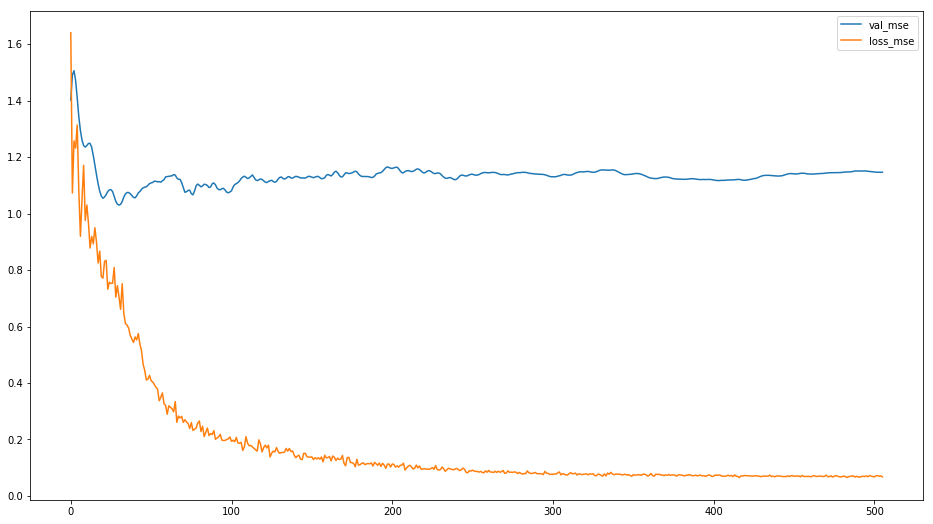

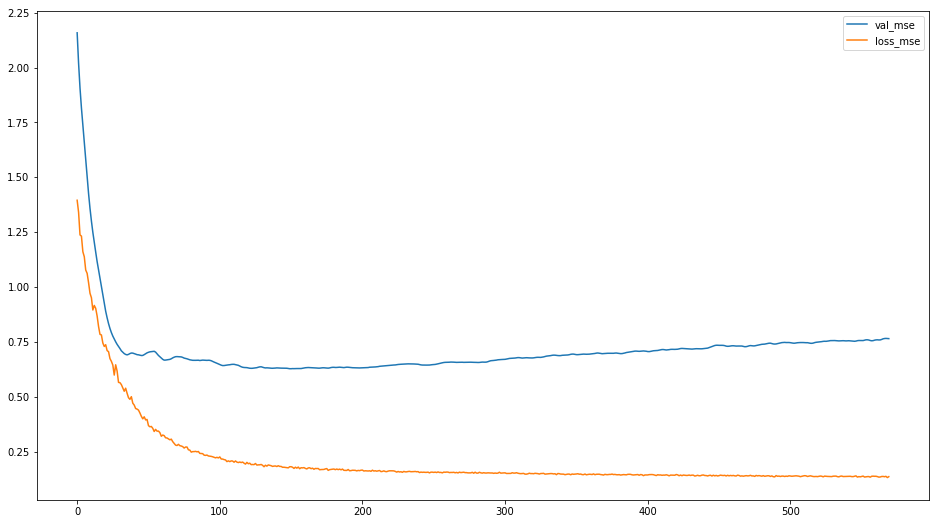

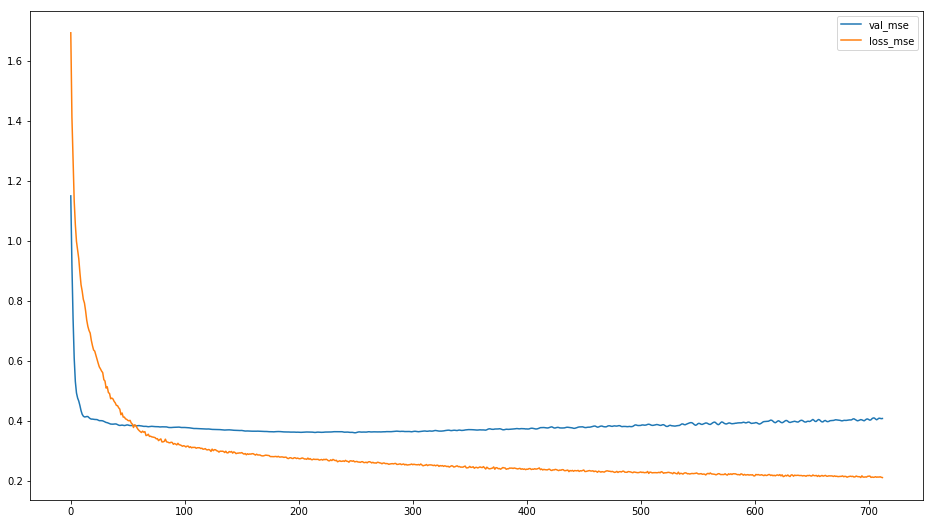

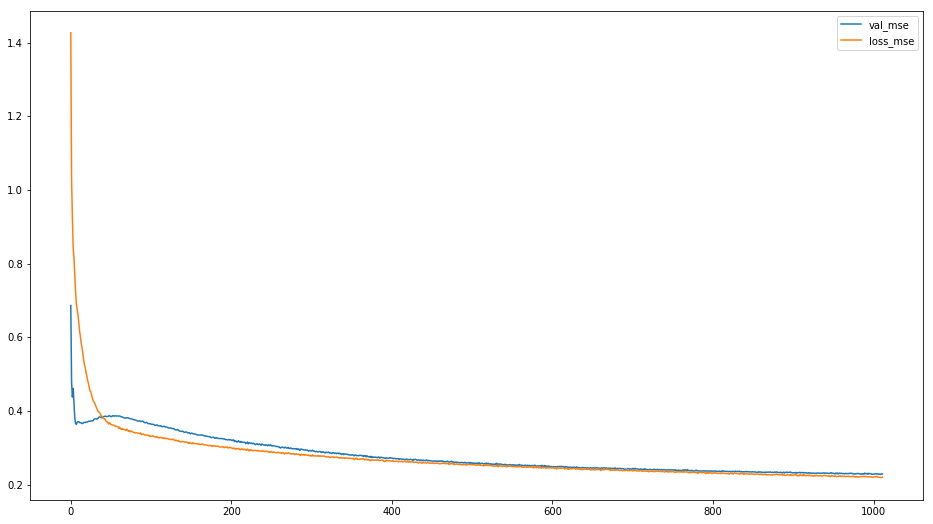

In [886]:
# train history
for size in sizes:
    a, b = 0, -1
    hval = full_hist_val[size][a:b]
    hloss = full_hist_loss[size][a:b]
    
    print(f'{size:5} {min(hval):.5} == {result_std[size]:.5}')
    
    plt.figure(figsize=(16,9))
    plt.plot(hval)
    plt.plot(hloss)
    plt.legend(['val_mse','loss_mse'])

In [887]:
for size in sizes:
    print(f'{size:5} {total["Neural"][size]:.5}')

  500 0.061593
 5000 0.037526
15000 0.021553
35976 0.013622


## LSTM

In [868]:
def train_test_time_series_split(dataset, target_name, look_back_n, look_back_step, train_predict_by, train_test_ratio=0.75, skip_train=0, skip_test=0):
    """
    Переводит датасет в 3D массив, который кушает LSTM. Это массив с shape = (n_series, n_look_back, n_feats)
    Делит на train и test
    """
    target_i = [i for i,col in enumerate(dataset.columns) if col==target][0]
    l = len(dataset)
    ndim = np.array(dataset).ndim
    dataset = np.array(dataset)
    
    if ndim == 1:
        n_features = 1
    elif ndim == 2:
        n_features = dataset.shape[1]
    else:
        raise BaseException('dataset ndim must be 1 or 2')
    
    dataset = dataset.reshape(l,n_features)
        
    n_series = l - look_back_n*look_back_step - train_predict_by
    
    train_size = round(train_test_ratio*n_series)
    v = train_size
    test_size = n_series - train_size
    train_size = int(np.ceil(train_size/(skip_train+1)))
    test_size = int(np.ceil(test_size/(skip_test+1)))
    
    trainX = []
    trainY = []
    for i in np.arange(train_size):
        trainX.append(dataset[[i*(skip_train+1)+k*look_back_step for k in range(look_back_n+1)] ] )
        trainY.append(dataset[i*(skip_train+1)+look_back_n*look_back_step+train_predict_by, target_i] )
    trainX = np.array(trainX).reshape(train_size, look_back_n+1, n_features)
    trainY = np.array(trainY).reshape(train_size)
    
    testX = []
    testY = []
    for i in np.arange(test_size):
        testX.append(dataset[[v+i*(skip_test+1)+k*look_back_step for k in range(look_back_n+1)] ] )
        testY.append(dataset[v+i*(skip_test+1)+look_back_n*look_back_step+train_predict_by, target_i] )
    testX = np.array(testX).reshape(test_size, look_back_n+1, n_features)
    testY = np.array(testY).reshape(test_size)
    
    
    return trainX, testX, trainY, testY

In [869]:
look_back_n = 5  # 5
look_back_step = 10  # 10
predict_by = 30  # 30

In [870]:
trainX_s, testX_s, trainY_s, testY_s = train_test_time_series_split(dataset_c, target, look_back_n, look_back_step, predict_by, train_test_ratio=0.75)

In [907]:
def NeuralLSTM():
#     np.random.seed(0)
    inputs = Input((look_back_n+1, n_feats))
    x = LSTM(200, activation='tanh')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    neural = Model(inputs=inputs, outputs=x)
    neural.compile(optimizer=optimizers.Adam(lr=0.01, decay=0.01/50), loss='mae', metrics=['mse'])
    return neural

In [911]:
total['NeuralLSTM'] = {}
sizes = [500,10000,len(trainX_s)]
# sizes = [len(trainX_s)]
full_hist_val = {}
full_hist_loss = {}
result_std = {}

for size in sizes:
    model = NeuralLSTM()
    
    model.fit(trainX_s[:size], trainY_s[:size], epochs=50+size//700, batch_size=10000, shuffle=False, validation_data=(testX_s, testY_s), verbose=1,
           callbacks=[ModelCheckpoint('tmp_model.hdf5', monitor='val_mean_squared_error', save_best_only=True, save_weights_only=True)])
    
    full_hist_val[size] = model.history.history['val_mean_squared_error']
    full_hist_loss[size] = model.history.history['mean_squared_error']
    
    model.load_weights('tmp_model.hdf5')
    preds = model.predict(testX_s)
    
    result_std[size] = mean_squared_error(preds, testY_s)
    result = mean_squared_error(un_stand_target(preds), un_stand_target(testY_s))
    print('\n----->', size, result, '\n')
    total['NeuralLSTM'][size] = result

Train on 500 samples, validate on 11980 samples
Epoch 1/50
500/500 [==============================] - 13s 27ms/step - loss: 0.8785 - mean_squared_error: 0.9945 - val_loss: 0.9478 - val_mean_squared_error: 1.5093
Epoch 2/50
500/500 [==============================] - 0s 630us/step - loss: 6.2062 - mean_squared_error: 39.1404 - val_loss: 1.1121 - val_mean_squared_error: 1.9087
Epoch 3/50
500/500 [==============================] - 0s 607us/step - loss: 3.8781 - mean_squared_error: 15.4056 - val_loss: 1.1819 - val_mean_squared_error: 2.1133
Epoch 4/50
500/500 [==============================] - 0s 614us/step - loss: 2.0570 - mean_squared_error: 4.4536 - val_loss: 1.2206 - val_mean_squared_error: 2.2551
Epoch 5/50
500/500 [==============================] - 0s 638us/step - loss: 0.5702 - mean_squared_error: 0.4244 - val_loss: 1.2563 - val_mean_squared_error: 2.4095
Epoch 6/50
500/500 [==============================] - 0s 617us/step - loss: 0.5801 - mean_squared_error: 0.4372 - val_loss: 1.2727


-----> 500 0.05930620472242284 

Train on 10000 samples, validate on 11980 samples
Epoch 1/64
10000/10000 [==============================] - 14s 1ms/step - loss: 0.7684 - mean_squared_error: 0.9335 - val_loss: 0.8607 - val_mean_squared_error: 1.2322
Epoch 2/64
10000/10000 [==============================] - 1s 78us/step - loss: 2.3938 - mean_squared_error: 10.8195 - val_loss: 0.8611 - val_mean_squared_error: 1.2729
Epoch 3/64
10000/10000 [==============================] - 1s 79us/step - loss: 1.2627 - mean_squared_error: 3.0615 - val_loss: 0.6820 - val_mean_squared_error: 0.7238
Epoch 4/64
10000/10000 [==============================] - 1s 78us/step - loss: 0.8284 - mean_squared_error: 1.0671 - val_loss: 0.6119 - val_mean_squared_error: 0.5692
Epoch 5/64
10000/10000 [==============================] - 1s 78us/step - loss: 0.5854 - mean_squared_error: 0.5613 - val_loss: 0.5949 - val_mean_squared_error: 0.5370
Epoch 6/64
10000/10000 [==============================] - 1s 78us/step - loss: 0

Epoch 50/64
10000/10000 [==============================] - 1s 77us/step - loss: 0.2787 - mean_squared_error: 0.1409 - val_loss: 1.1214 - val_mean_squared_error: 2.2883
Epoch 51/64
10000/10000 [==============================] - 1s 78us/step - loss: 0.2780 - mean_squared_error: 0.1404 - val_loss: 1.1148 - val_mean_squared_error: 2.2642
Epoch 52/64
10000/10000 [==============================] - 1s 81us/step - loss: 0.2758 - mean_squared_error: 0.1388 - val_loss: 1.1175 - val_mean_squared_error: 2.2781
Epoch 53/64
10000/10000 [==============================] - 1s 79us/step - loss: 0.2743 - mean_squared_error: 0.1365 - val_loss: 1.1220 - val_mean_squared_error: 2.2962
Epoch 54/64
10000/10000 [==============================] - 1s 80us/step - loss: 0.2717 - mean_squared_error: 0.1334 - val_loss: 1.1131 - val_mean_squared_error: 2.2626
Epoch 55/64
10000/10000 [==============================] - 1s 78us/step - loss: 0.2694 - mean_squared_error: 0.1310 - val_loss: 1.1108 - val_mean_squared_error:

35939/35939 [==============================] - 2s 61us/step - loss: 0.2294 - mean_squared_error: 0.0899 - val_loss: 0.3591 - val_mean_squared_error: 0.3122
Epoch 83/101
35939/35939 [==============================] - 2s 61us/step - loss: 0.2267 - mean_squared_error: 0.0876 - val_loss: 0.3514 - val_mean_squared_error: 0.3011
Epoch 84/101
35939/35939 [==============================] - 2s 62us/step - loss: 0.2276 - mean_squared_error: 0.0887 - val_loss: 0.3506 - val_mean_squared_error: 0.3011
Epoch 85/101
35939/35939 [==============================] - 2s 61us/step - loss: 0.2259 - mean_squared_error: 0.0857 - val_loss: 0.3506 - val_mean_squared_error: 0.2913
Epoch 86/101
35939/35939 [==============================] - 2s 61us/step - loss: 0.2256 - mean_squared_error: 0.0864 - val_loss: 0.3551 - val_mean_squared_error: 0.3114
Epoch 87/101
35939/35939 [==============================] - 2s 61us/step - loss: 0.2233 - mean_squared_error: 0.0839 - val_loss: 0.3475 - val_mean_squared_error: 0.2864

  500 0.99205 == 0.99183
10000 0.70801 == 0.5121
35939 0.22303 == 0.22303


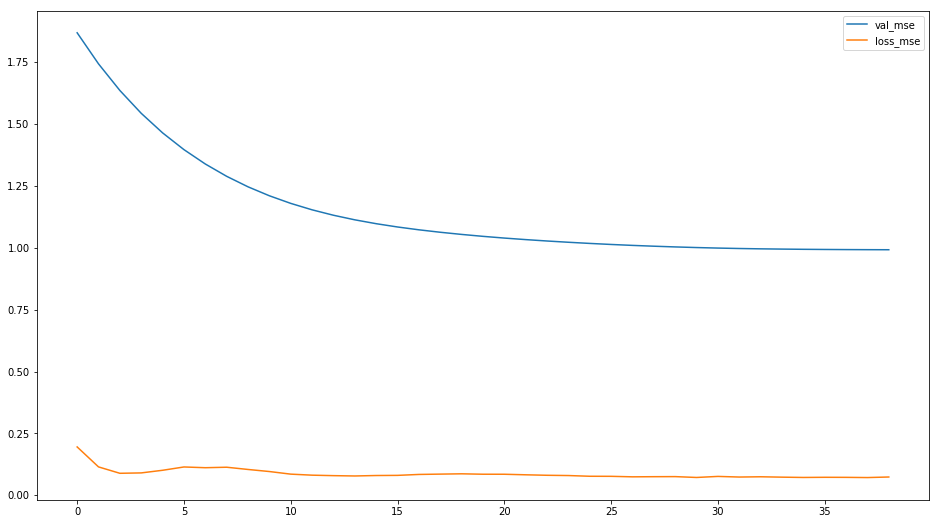

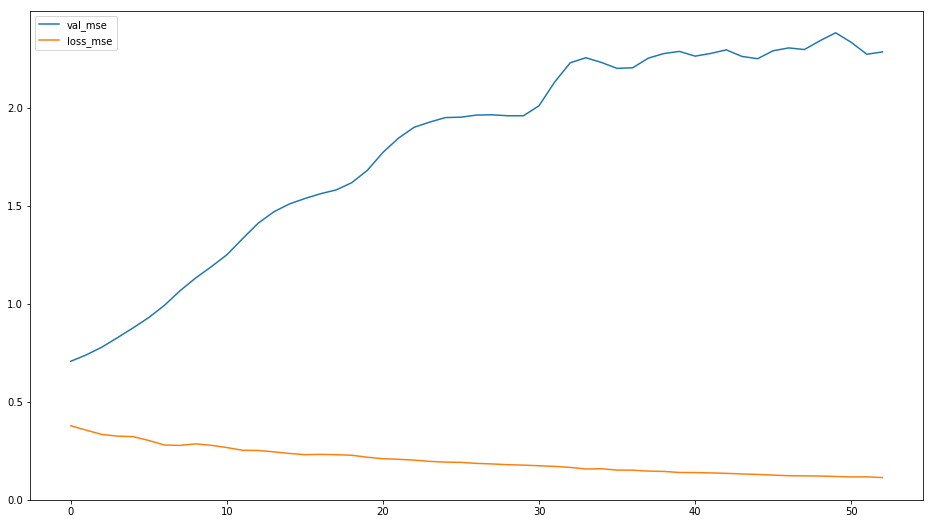

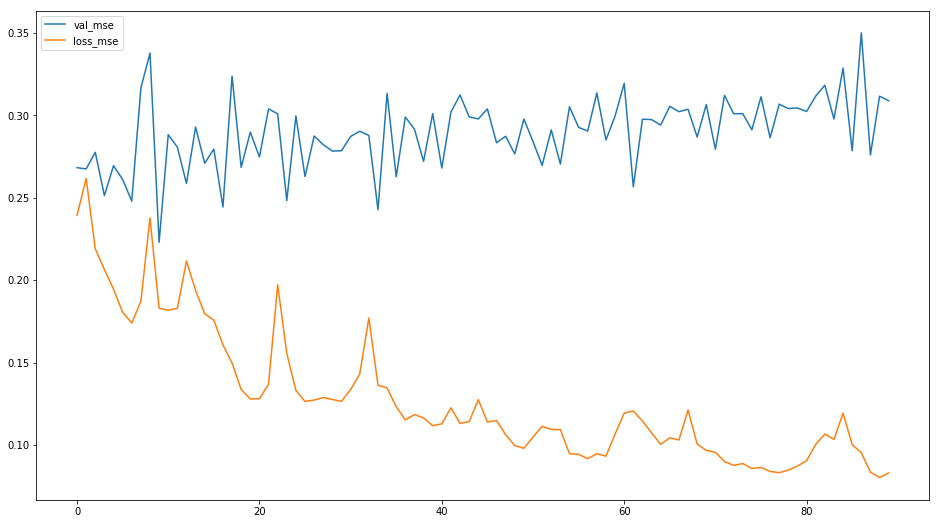

In [913]:
# train history
for size in sizes:
    a, b = 10, -1
    hval = full_hist_val[size][a:b]
    hloss = full_hist_loss[size][a:b]
    
    print(f'{size:5} {min(hval):.5} == {result_std[size]:.5}')
    
    plt.figure(figsize=(16,9))
    plt.plot(hval)
    plt.plot(hloss)
    plt.legend(['val_mse','loss_mse'])

In [914]:
for size in sizes:
    print(f'{size:5} {total["NeuralLSTM"][size]:.5}')

  500 0.059306
10000 0.030621
35939 0.013336


## Dummy

In [62]:
dummy = mean_squared_error(un_stand_target(testX[target+str(-shift)]), un_stand_target(testY))
total['Dummy'] = {sizes[0]:dummy, sizes[-1]: dummy}
total['Dummy'][sizes[0]]

0.037397560467740884

## Results

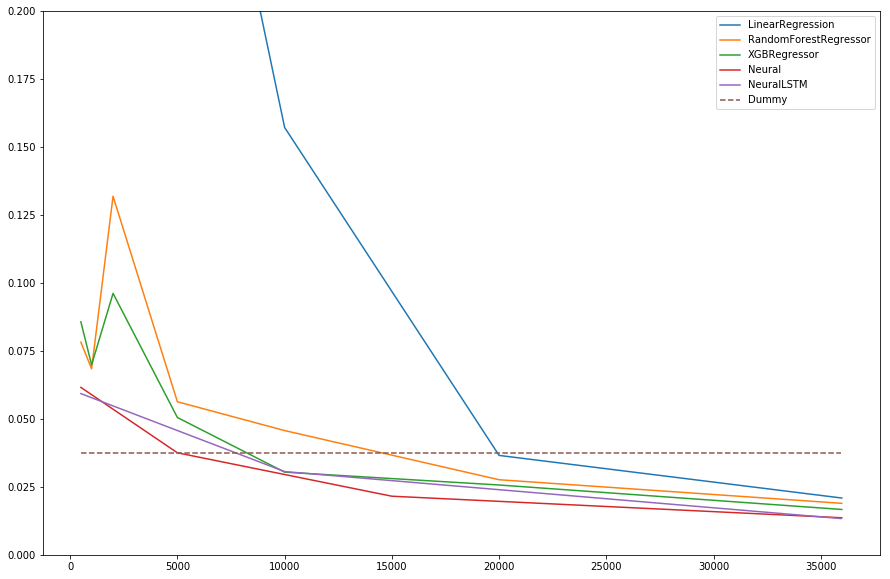

In [917]:
plt.figure(figsize=(15,10))
for name, results in total.items():
    if name == 'Dummy':
        ls = '--'
    else:
        ls = '-'
    plt.plot(results.keys(), results.values(), ls=ls)
plt.legend(total.keys())
plt.ylim((0,0.2));